In [1]:
!pip install category_encoders

# 1. Import Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, make_scorer
import math
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import cm
colormap = cm.tab10

# 2. Data Loading & Splitting

In [3]:
# Load dataset
df = pd.read_csv('live_sellings.xls')
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [4]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_254856844631452,photo,8/9/2012 3:24,36,16,0,36,0,0,0,0,0,NaN,NaN,NaN,NaN
1,246675545449582_535214943262306,video,4/15/2014 23:55,699,10,2,699,0,0,0,0,0,NaN,NaN,NaN,NaN
2,614855718638584_783400835117404,video,4/4/2018 6:30,122,307,131,87,33,0,0,1,1,NaN,NaN,NaN,NaN
3,1050855161656896_1400966946645714,video,9/21/2017 8:06,79,8,0,79,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1592459934204463,video,2/26/2018 8:50,171,292,28,150,19,1,1,0,0,NaN,NaN,NaN,NaN


# 3. EDA & Data Preprocessing

In [5]:
# Size of Dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 7050
Number of columns: 16


In [6]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

In [7]:
# Drop unnecessary & duplicated columns
df = df.drop(['status_id'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['status_published'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Column1'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Column2'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Column3'], axis=1)
df = df.reset_index(drop=True)
df = df.drop(['Column4'], axis=1)
df = df.reset_index(drop=True)
df.columns

Index(['status_type', 'num_reactions', 'num_comments', 'num_shares',
       'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads',
       'num_angrys'],
      dtype='object')

In [8]:
# Remove duplicated columns
# This will retain the first occurrences, change as you want
dup_cols = df.columns.duplicated()
cols = list(df.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

df = df.loc[:,~df.columns.duplicated()].copy()

print("After removing...")

dup_cols = df.columns.duplicated()
cols = list(df.columns)
print(f"Duplicated Columns: \n{[cols[i] for i in range(len(cols)) if dup_cols[i]]}")

Duplicated Columns: 
[]
After removing...
Duplicated Columns: 
[]


In [9]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    7050 non-null   object
 1   num_reactions  7050 non-null   int64 
 2   num_comments   7050 non-null   int64 
 3   num_shares     7050 non-null   int64 
 4   num_likes      7050 non-null   int64 
 5   num_loves      7050 non-null   int64 
 6   num_wows       7050 non-null   int64 
 7   num_hahas      7050 non-null   int64 
 8   num_sads       7050 non-null   int64 
 9   num_angrys     7050 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 550.9+ KB


In [10]:
# Remove row with missing values
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    7050 non-null   object
 1   num_reactions  7050 non-null   int64 
 2   num_comments   7050 non-null   int64 
 3   num_shares     7050 non-null   int64 
 4   num_likes      7050 non-null   int64 
 5   num_loves      7050 non-null   int64 
 6   num_wows       7050 non-null   int64 
 7   num_hahas      7050 non-null   int64 
 8   num_sads       7050 non-null   int64 
 9   num_angrys     7050 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 550.9+ KB


In [11]:
# Drop duplicated rows
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop=True)
print()
print("Removing duplicates...")
print()
print("Number of duplicated rows:", df.shape[0] - df.drop_duplicates().shape[0])

Number of duplicated rows: 2063

Removing duplicates...

Number of duplicated rows: 0


In [12]:
# # Rename columns
# headers = ["carat", "cut", "color",
#            "clarity", "depth (%)", "table", "price",
#            "length (mm)", "width (mm)", "depth (mm)"]
# df.columns = headers
# df.columns

In [13]:
# Show unique values on each columns
for col in df.columns:
    print(df[col].value_counts())

status_type
photo     2707
video     1869
status     351
link        60
Name: count, dtype: int64
num_reactions
22      40
14      40
19      39
16      37
30      37
        ..
2674     1
1970     1
511      1
2383     1
2349     1
Name: count, Length: 1067, dtype: int64
num_comments
0       682
1       326
2       257
3       235
4       196
       ... 
5204      1
1776      1
1360      1
2092      1
909       1
Name: count, Length: 993, dtype: int64
num_shares
0      2051
1       679
2       301
3       161
4       105
       ... 
346       1
915       1
330       1
536       1
750       1
Name: count, Length: 501, dtype: int64
num_likes
27      42
14      41
22      41
24      40
35      37
        ..
2025     1
426      1
2157     1
1344     1
978      1
Name: count, Length: 1044, dtype: int64
num_loves
0      2285
1       539
2       279
3       204
4       127
       ... 
326       1
265       1
278       1
228       1
336       1
Name: count, Length: 229, dtype: int64
num_wows


In [14]:
# # Drop poor features (to avoid overfitting)
# df = df.drop(['VendorID'], axis=1)
# df = df.reset_index(drop=True)
# df = df.drop(['payment_type'], axis=1)
# df = df.reset_index(drop=True)
# df.columns

In [15]:
# # Remove invalid row
# df = df[df["Bare Nuclei"] != "?"]

# for col in df.columns:
#     print(df[col].value_counts())

In [16]:
# Check invalid datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    4987 non-null   object
 1   num_reactions  4987 non-null   int64 
 2   num_comments   4987 non-null   int64 
 3   num_shares     4987 non-null   int64 
 4   num_likes      4987 non-null   int64 
 5   num_loves      4987 non-null   int64 
 6   num_wows       4987 non-null   int64 
 7   num_hahas      4987 non-null   int64 
 8   num_sads       4987 non-null   int64 
 9   num_angrys     4987 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 389.7+ KB


In [17]:
# # Change the data type of invalid columns
# df["Target class"] = df["Target class"].astype("int64")
# df.info()

In [18]:
# Show categorical columns
categorical_cols = list(set(df.columns.to_list()) - set(df._get_numeric_data().columns.to_list()))

print("Categorical columns:")
print(sorted(categorical_cols))

Categorical columns:
['status_type']


In [19]:
# Show unique values in categorical columns
unique_values = []

for col in categorical_cols:
    unique_value = [col]
    unique_value.append(", ".join(df[col].unique()))
    unique_values.append(unique_value)

pd.DataFrame(unique_values, columns=["col", "unique values"])

,col,unique values
0,status_type,"photo, video, status, link"


In [20]:
# Encode nominal data
df = pd.get_dummies(df, columns=['status_type'], drop_first=True)
df

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_type_photo,status_type_status,status_type_video
0,36,16,0,36,0,0,0,0,0,True,False,False
1,699,10,2,699,0,0,0,0,0,False,False,True
2,122,307,131,87,33,0,0,1,1,False,False,True
3,79,8,0,79,0,0,0,0,0,False,False,True
4,171,292,28,150,19,1,1,0,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4982,178,0,0,171,7,0,0,0,0,True,False,False
4983,144,383,196,87,54,0,3,0,0,False,False,True
4984,3919,77,12,3919,0,0,0,0,0,False,False,True
4985,149,18,2,140,4,5,0,0,0,True,False,False


In [21]:
# # Encode ordinal data

# enc_maps = {
#     "cut" : [{'col': "cut", 'mapping': {"Fair": 0, "Good": 1, "Very Good": 2, "Premium": 3, "Ideal": 4}}],
#     "color" : [{'col': "color", 'mapping': {"D": 0, "E": 1, "F": 2, "G": 3, "H": 4, "I": 5, "J": 6}}],
#     "clarity" : [{'col': "clarity", 'mapping': {"FL": 0, "IF": 1, "VVS1": 2, "VVS2": 3, "VS1": 4, "VS2": 5, "SI1": 6, "SI2": 7, "l1": 8, "l2": 9, "l3": 10}}],
# }

# for col in categorical_cols:
#     enc_map = enc_maps[col]

#     enc = OrdinalEncoder(mapping=enc_map)
#     df = enc.fit_transform(df)


# df

<Axes: >

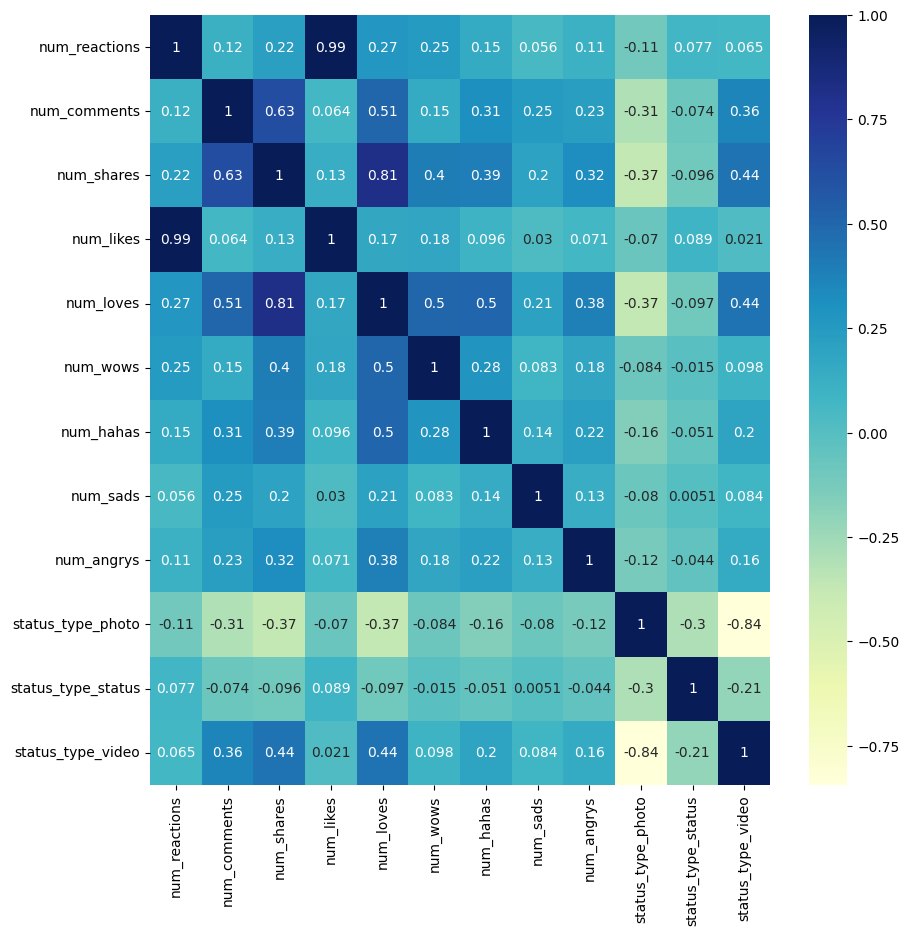

In [22]:
# Displaying heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method="pearson"), cmap="YlGnBu", annot=True)

In [23]:
# # Drop correlated features
# df = df.drop(['num_comments'], axis=1)
# df = df.reset_index(drop=True)
# df.columns

### 3.1 Outliers detection

In [24]:
# Show all numerical columns
numerical_columns = list(df.select_dtypes(include=[np.number]).columns.values)
numerical_columns

['num_reactions',
 'num_comments',
 'num_shares',
 'num_likes',
 'num_loves',
 'num_wows',
 'num_hahas',
 'num_sads',
 'num_angrys']

In [25]:
# Detect outliers
def detect_outliers_iqr(df, column):
    """
    Detect outliers using IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

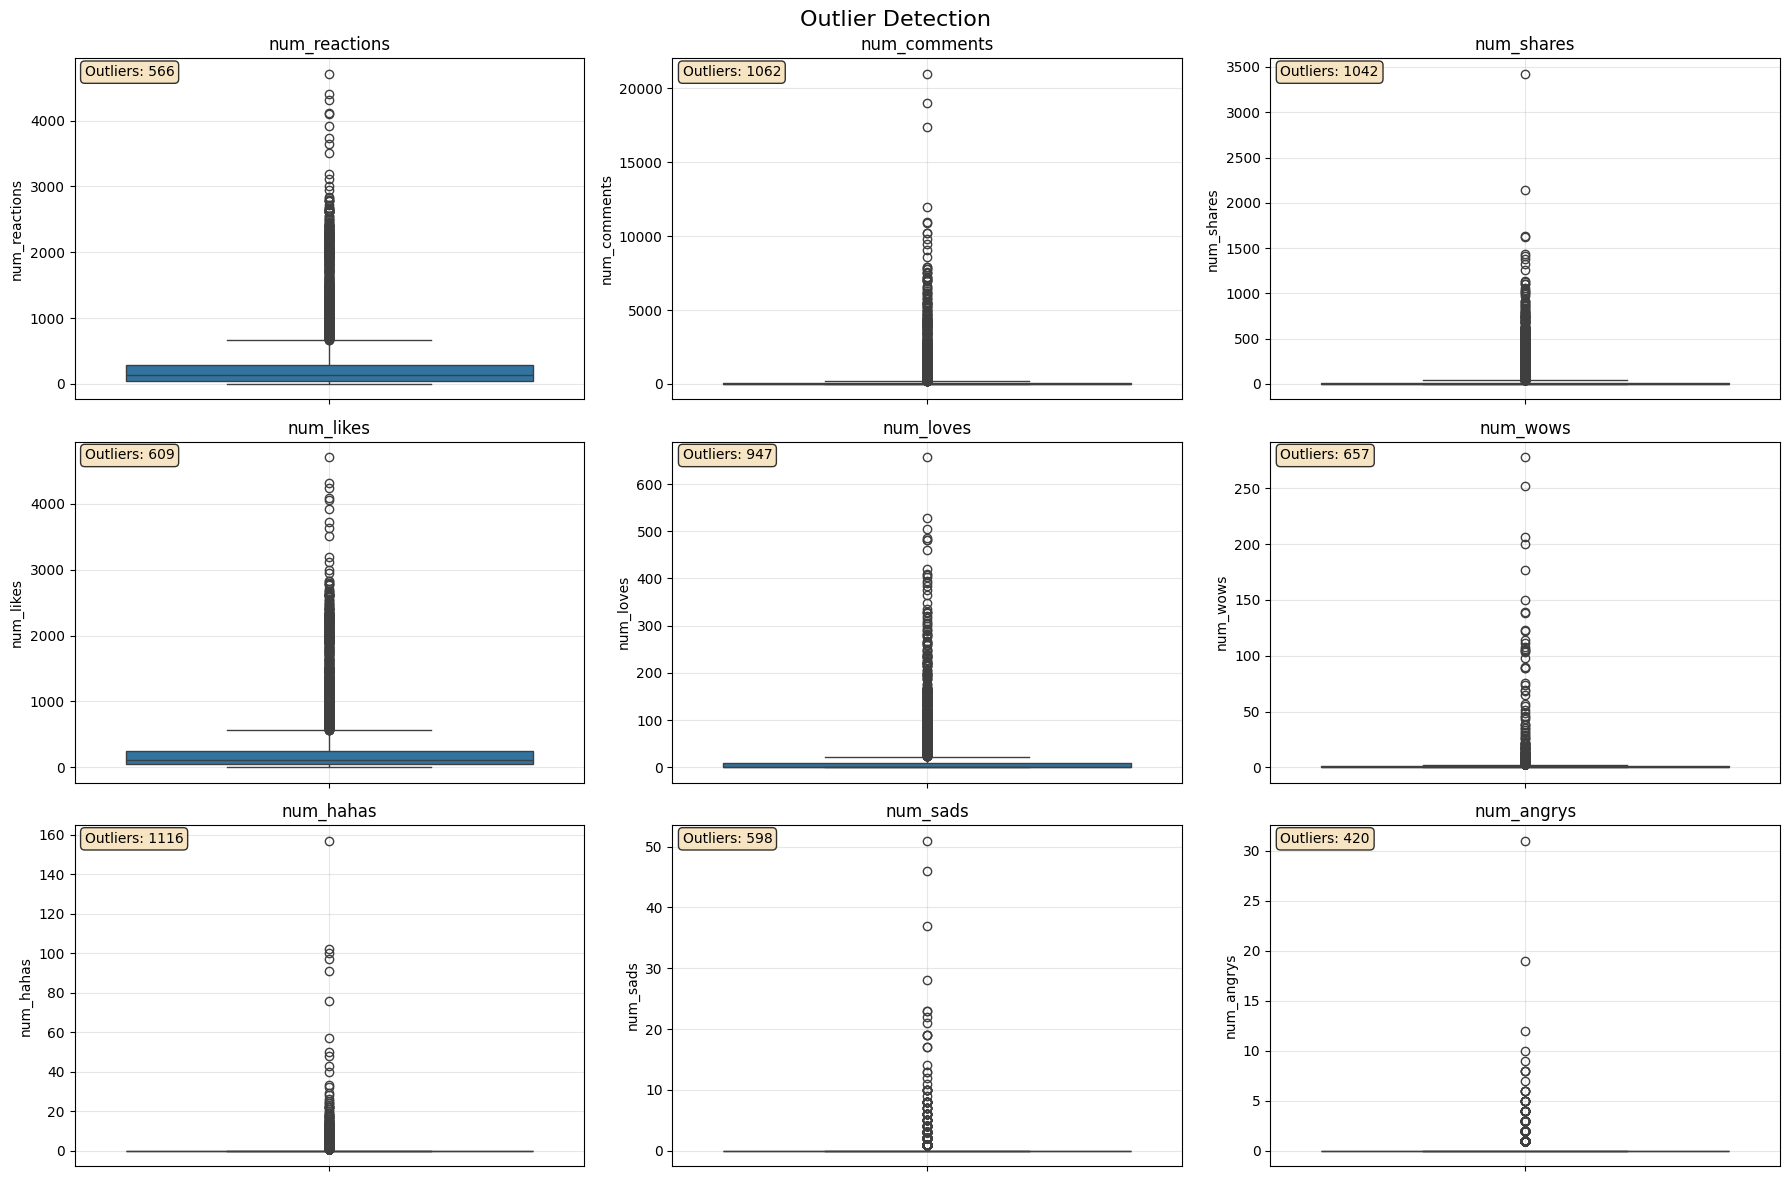

In [26]:
# Create box plots for all numerical features to visualize outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Outlier Detection', fontsize=16)

lower_bounds = dict()
upper_bounds = dict()

for i, col in enumerate(numerical_columns):
    row = i // 3
    col_idx = i % 3

    # Create box plot
    sns.boxplot(data=df, y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].grid(True, alpha=0.3)

    # Add outlier count as text
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    lower_bounds[col] = lower_bound
    upper_bounds[col] = upper_bound

    axes[row, col_idx].text(0.02, 0.98, f'Outliers: {len(outliers)}',
                           transform=axes[row, col_idx].transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [27]:
# # Remove same outliers (skip this if you want to remove all outliers)

# print(f"Number of rows: {df.shape[0]}")

# print("\nRemoving outliers...\n")

# outlier_condition = True
# for col in numerical_columns:
#     # A row is an outlier if it's OUTSIDE the bounds (< lower OR > upper)
#     outlier_condition = outlier_condition & ((df[col] < lower_bounds[col]) | (df[col] > upper_bounds[col]))

# # Remove rows that are outliers in ALL columns
# df = df[~outlier_condition]
# df = df.reset_index(drop=True)

# print(f"Number of rows: {df.shape[0]}")

In [28]:
# # Remove individual outliers (only if the dataset is big enough)

# print(f"Number of rows: {df.shape[0]}")

# print("\nRemoving outliers...\n")

# for i, col in enumerate(numerical_columns):

#     df = df[df[col] >= lower_bounds[col]]
#     df = df.reset_index(drop=True)
#     df = df[df[col] <= upper_bounds[col]]
#     df = df.reset_index(drop=True)

# print(f"Number of rows: {df.shape[0]}")

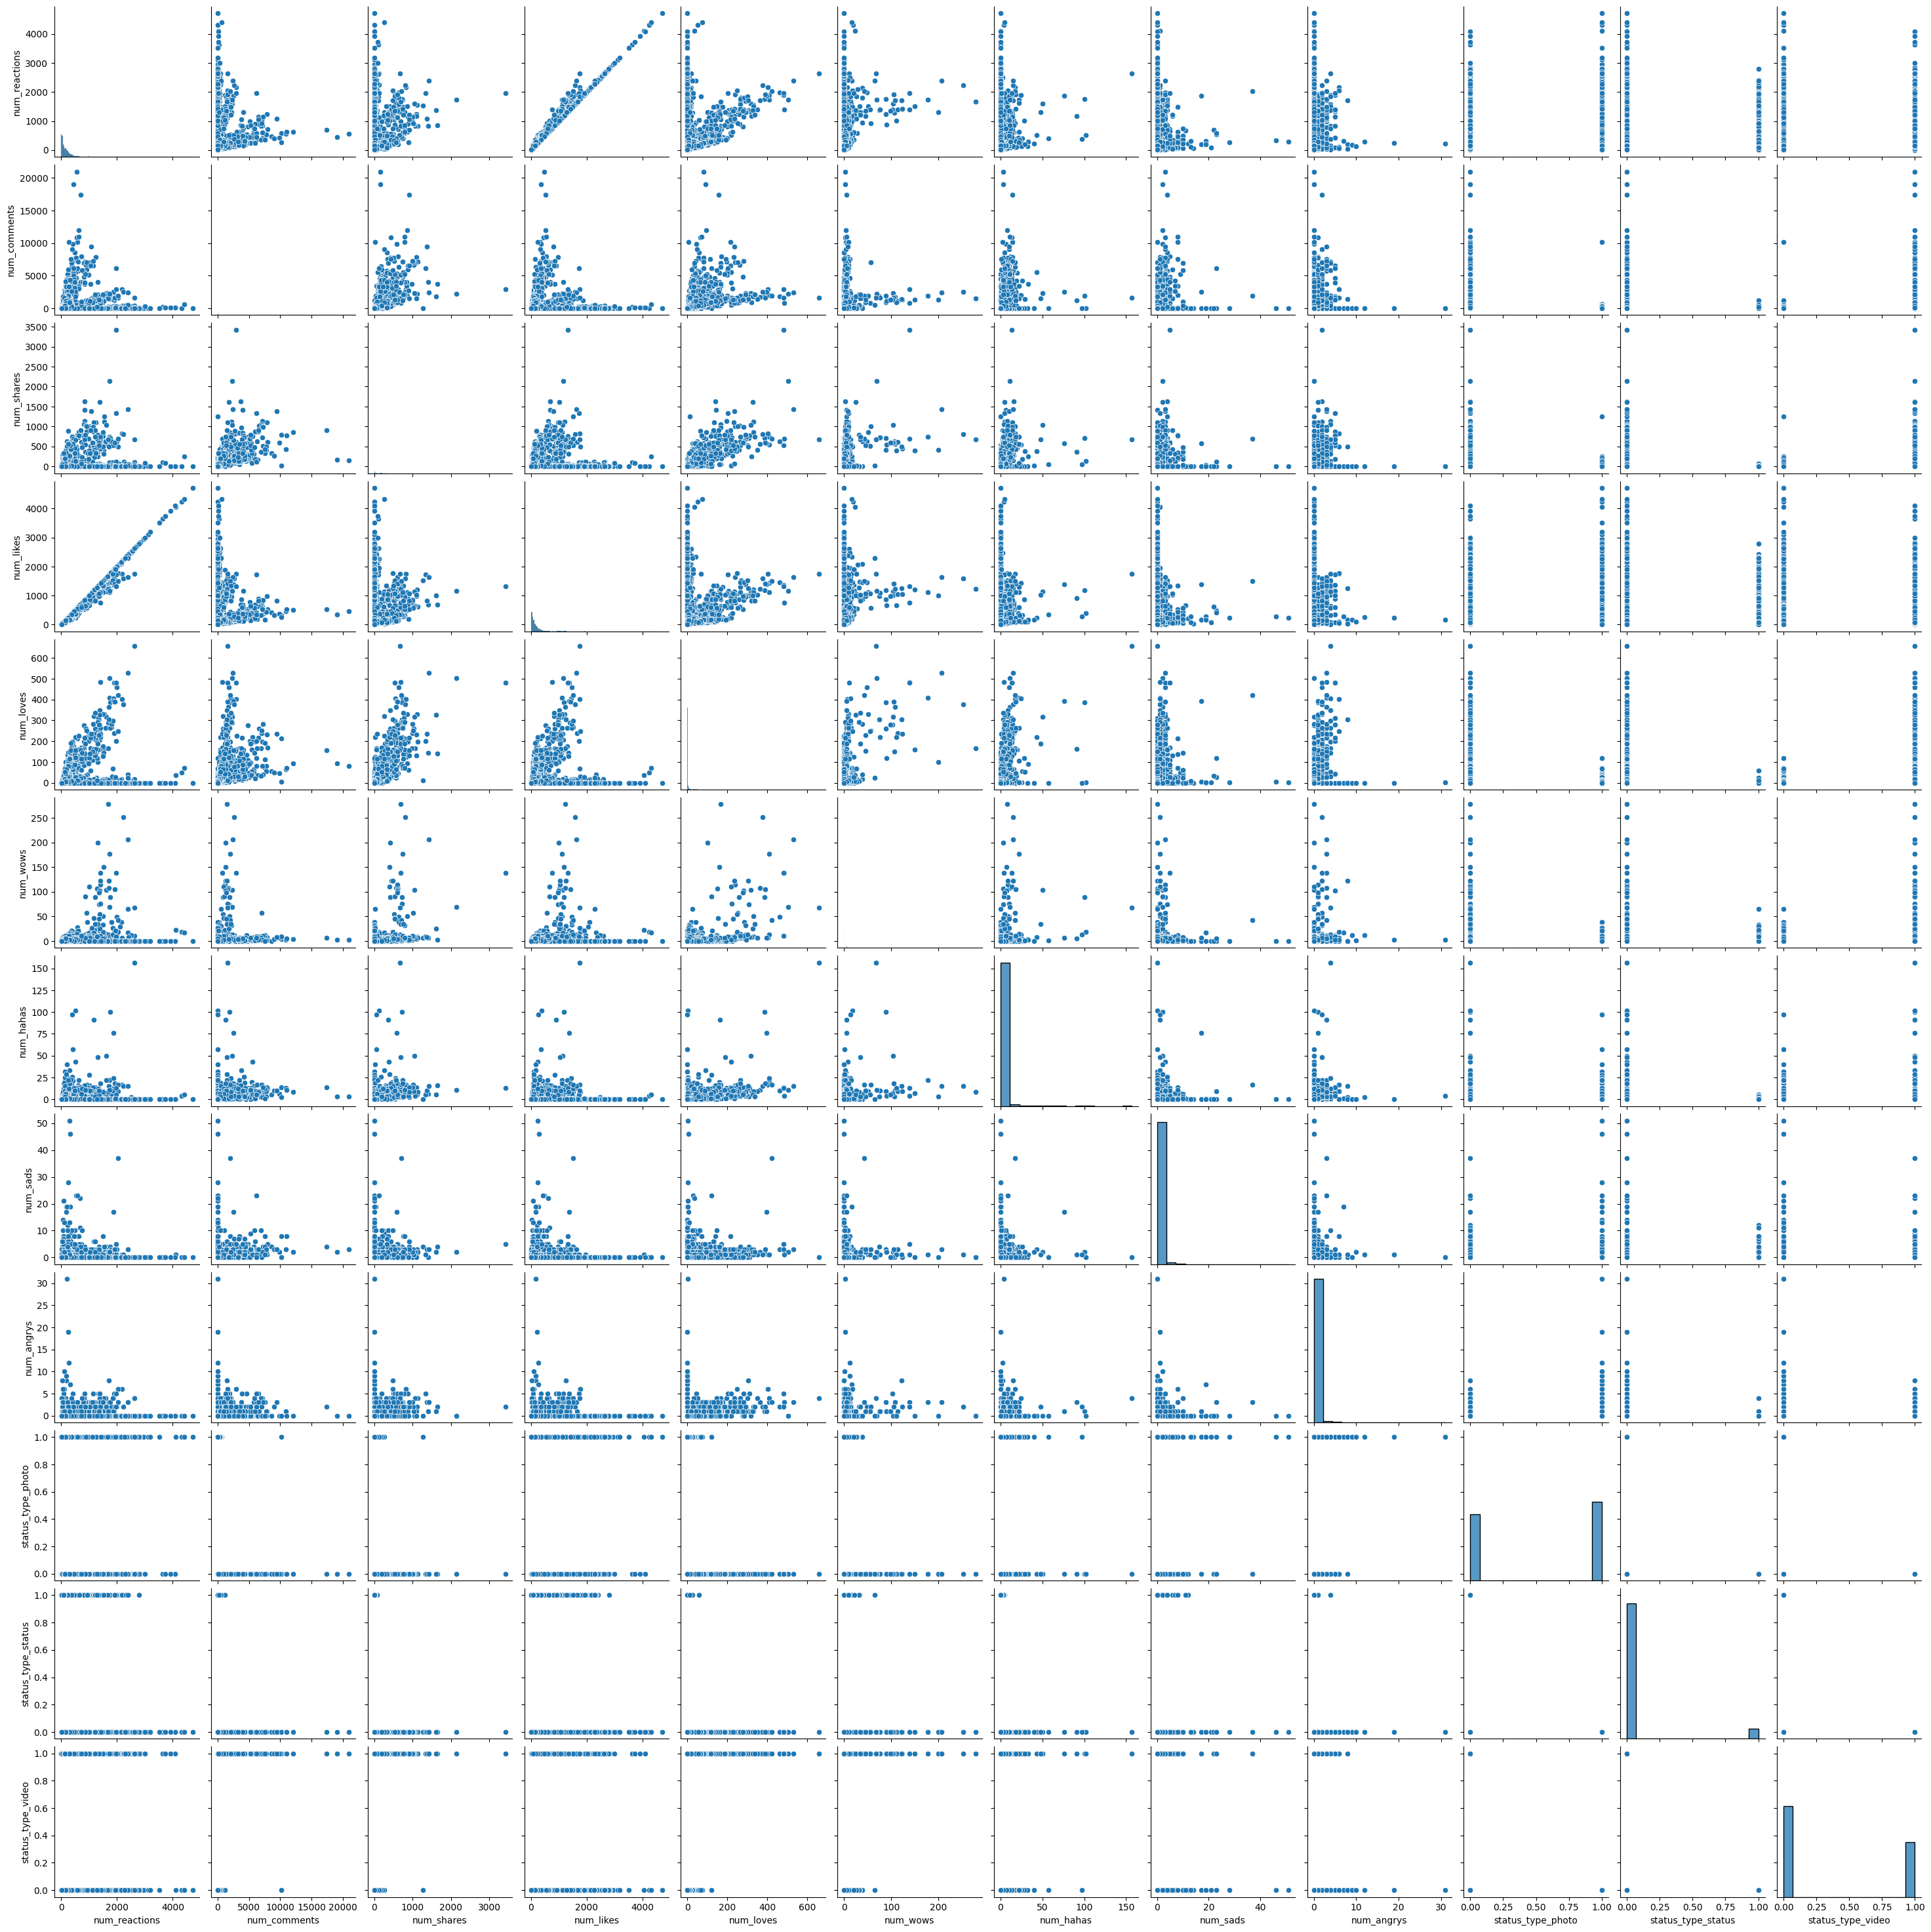

In [29]:
# Show the distribution of all columns
sns.pairplot(df)

In [30]:
# Show statistical information of the dataset
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000
mean,309.569080,316.201925,56.455986,288.466413,17.881893,1.756567,0.979346,0.326449,0.154602
std,512.255183,1044.033761,153.490871,499.145306,46.541067,10.294329,4.674973,1.745922,0.811544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,2.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,134.000000,10.000000,1.000000,113.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,292.000000,89.000000,16.000000,254.000000,9.000000,1.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


In [31]:
# # MinMax Scaling
# numeric_cols = df.select_dtypes(include='number').columns

# scaler = MinMaxScaler()

# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
# df[numeric_cols]

In [32]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000,4987.000000
mean,309.569080,316.201925,56.455986,288.466413,17.881893,1.756567,0.979346,0.326449,0.154602
std,512.255183,1044.033761,153.490871,499.145306,46.541067,10.294329,4.674973,1.745922,0.811544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,2.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,134.000000,10.000000,1.000000,113.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,292.000000,89.000000,16.000000,254.000000,9.000000,1.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


# 4. K-Means Clustering

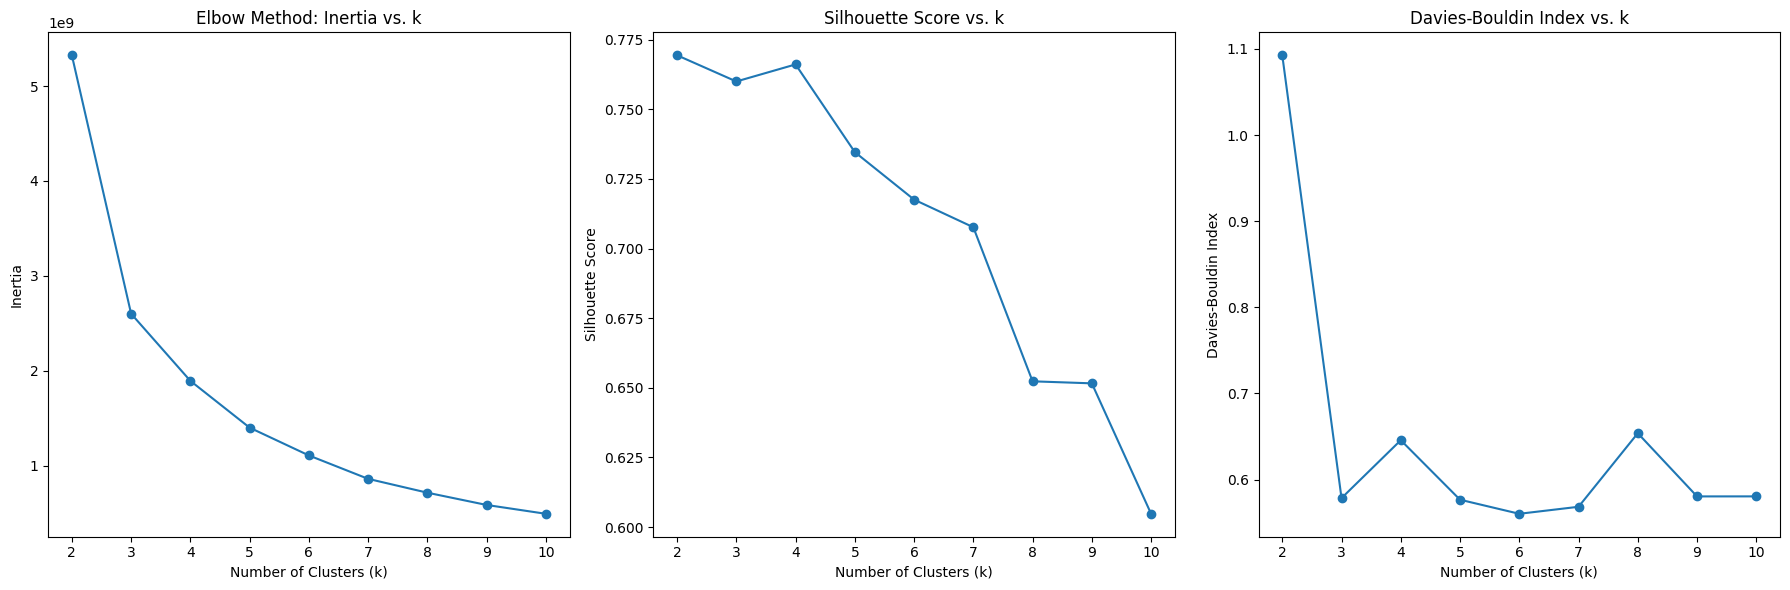

In [33]:
# Evaluate the model

def evaluate_model(df):
    # Range of k values to test
    k_values = range(2, 11)

    # Store performance metrics
    inertia_values = []
    silhouette_scores = []
    davies_bouldin_indices = []

    for k in k_values:
        model = KMeans(n_clusters=k, random_state=42)
        y_kmeans = model.fit_predict(df)

        # Calculate and store metrics
        inertia_values.append(model.inertia_)
        silhouette_scores.append(silhouette_score(df, y_kmeans))
        davies_bouldin_indices.append(davies_bouldin_score(df, y_kmeans))

    # Plot the inertia values (Elbow Method)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method: Inertia vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')

    # Plot silhouette scores
    plt.subplot(1, 3, 2)
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')

    # Plot Davies-Bouldin Index
    plt.subplot(1, 3, 3)
    plt.plot(k_values, davies_bouldin_indices, marker='o')
    plt.title('Davies-Bouldin Index vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

evaluate_model(df)

In [34]:
model = KMeans(n_clusters=3, random_state=42)
y_kmeans = model.fit_predict(df)
print("Model's inertia: ", model.inertia_)
print("Model's silhouette score: ", silhouette_score(df, y_kmeans))
print("Model's davies bouldin score: ", davies_bouldin_score(df, y_kmeans))
print()
pd.DataFrame(y_kmeans, columns=["cluster"])

Model's inertia:  2601770644.7604666
Model's silhouette score:  0.7599630594037541
Model's davies bouldin score:  0.5783942331113395



,cluster
0,0
1,0
2,0
3,0
4,0
...,...
4982,0
4983,0
4984,2
4985,0


# 5. Tuning

In [40]:
# Define a custom scorer for Silhouette Score
def silhouette_scorer(estimator, df):
    labels = estimator.fit_predict(df)
    return silhouette_score(df, labels)

In [41]:
base_model = KMeans(random_state=42)

params = {
    'n_clusters': [3],
    "init": ["k-means++", "random"],
    "algorithm": ["lloyd", "elkan"],

}

grid_search = GridSearchCV(estimator=base_model,
                           param_grid=params,
                           cv=5, n_jobs=-1, verbose=1, scoring = silhouette_scorer)

In [42]:
%%time
grid_search.fit(df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 84.9 ms, sys: 7.99 ms, total: 92.9 ms
Wall time: 1.12 s


GridSearchCV(cv=5, estimator=KMeans(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['lloyd', 'elkan'],
                         'init': ['k-means++', 'random'], 'n_clusters': [3]},
             scoring=<function silhouette_scorer at 0x7cc588b47380>, verbose=1)

In [43]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_n_clusters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.062741,0.006734,0.059179,0.008465,lloyd,random,3,"{'algorithm': 'lloyd', 'init': 'random', 'n_cl...",0.773472,0.762860,0.768452,0.748173,0.752844,0.761160,0.009439,1
3,0.088239,0.013072,0.079992,0.014807,elkan,random,3,"{'algorithm': 'elkan', 'init': 'random', 'n_cl...",0.773472,0.762860,0.768452,0.748173,0.752844,0.761160,0.009439,1
0,0.013832,0.002095,0.033863,0.000426,lloyd,k-means++,3,"{'algorithm': 'lloyd', 'init': 'k-means++', 'n...",0.776367,0.761032,0.768452,0.749014,0.715416,0.754056,0.021317,3
2,0.016511,0.003667,0.036283,0.002429,elkan,k-means++,3,"{'algorithm': 'elkan', 'init': 'k-means++', 'n...",0.776367,0.761032,0.768452,0.749014,0.715416,0.754056,0.021317,3


In [44]:
best_params = grid_search.best_estimator_
best_params

KMeans(init='random', n_clusters=3, random_state=42)

In [45]:
y_kmeans = best_params.fit_predict(df)
print("Best model's inertia: ", best_params.inertia_)
print("Best model's silhouette score: ", silhouette_score(df, y_kmeans))
print("Best model's davies bouldin score: ", davies_bouldin_score(df, y_kmeans))
print()
pd.DataFrame(y_kmeans, columns=["cluster"])

Best model's inertia:  2601770644.7604666
Best model's silhouette score:  0.7599630594037541
Best model's davies bouldin score:  0.5783942331113395



,cluster
0,0
1,0
2,0
3,0
4,0
...,...
4982,0
4983,0
4984,2
4985,0
